# Example to use ODA

In [3]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import matplotlib.pyplot as plt

from utils.cococls import get_cls

import numpy as np

In [4]:
cococlass = get_cls() # for viz
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/ken/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
14.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

50.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

86.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set t

## load img

In [6]:
def loadimg(path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    img = cv2.imread(path)
    img = cv2.resize(img, (1024,1024))
    img = img.transpose([2,0,1]) / 255 # 0-1 float!
    return torch.from_numpy(img).unsqueeze(0).to(device).float()

# Execute TTA with ODA

In [9]:
import odach as oda

In [10]:
# Declare TTA variations
tta = [oda.VerticalFlip(), oda.Multiply(0.9), oda.Multiply(1.1)]
scale = [0.8, 0.9, 1, 1.1, 1.2]
# load image
impath = "imgs/cars3.jpg"
img = loadimg(impath)
# wrap model and tta
tta_model = oda.TTAWrapper(model, tta, scale)
# Execute TTA!
boxes, scores, labels = tta_model(img)

preparing tta for multiscale..


/home/ken/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


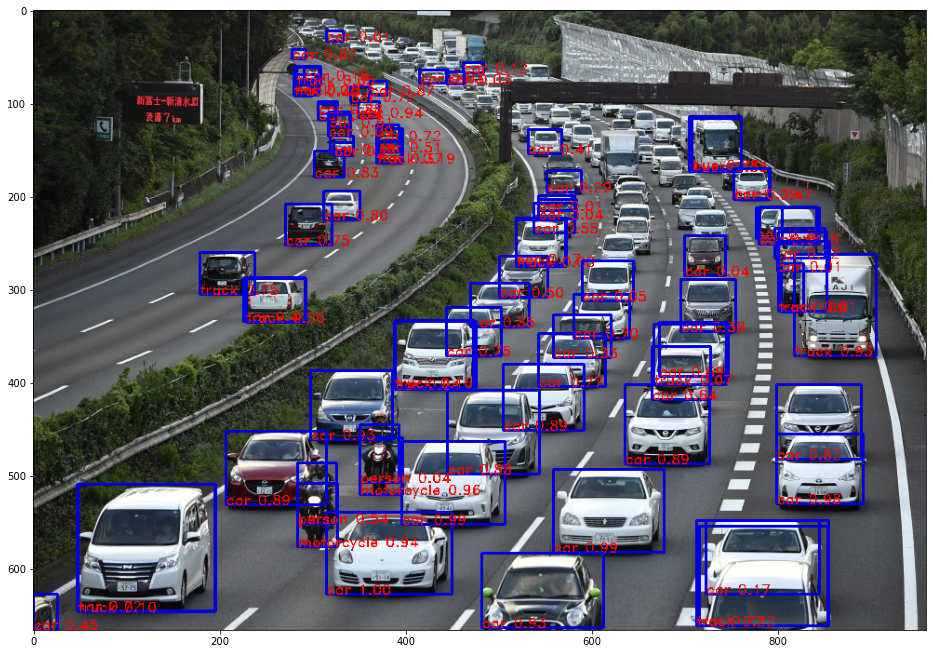

In [11]:
# Viz
fig = plt.figure(figsize=(16,16))
sample = cv2.imread(impath)
# rescale boxes to image size
boxes[:,0] *= sample.shape[1]
boxes[:,2] *= sample.shape[1]
boxes[:,1] *= sample.shape[0]
boxes[:,3] *= sample.shape[0]
for i, box in enumerate(boxes):
    cv2.rectangle(sample,
              (int(box[0]), int(box[1])),
              (int(box[2]), int(box[3])),
              220, 2)
    cv2.putText(sample, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),  
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction class

plt.imshow(sample[:,:,::-1])#BGR2RGB
plt.show()

## Multiscale only

In [12]:
# Declare TTA variations
tta = [oda.Multiply(1)]
scale = [0.8, 0.9, 1, 1.1, 1.2]
# load image
impath = "imgs/cars3.jpg"
img = loadimg(impath)
# wrap model and tta
tta_model = oda.TTAWrapper(model, tta, scale)
# Execute TTA!
boxes, scores, labels = tta_model(img)

preparing tta for multiscale..


/home/ken/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


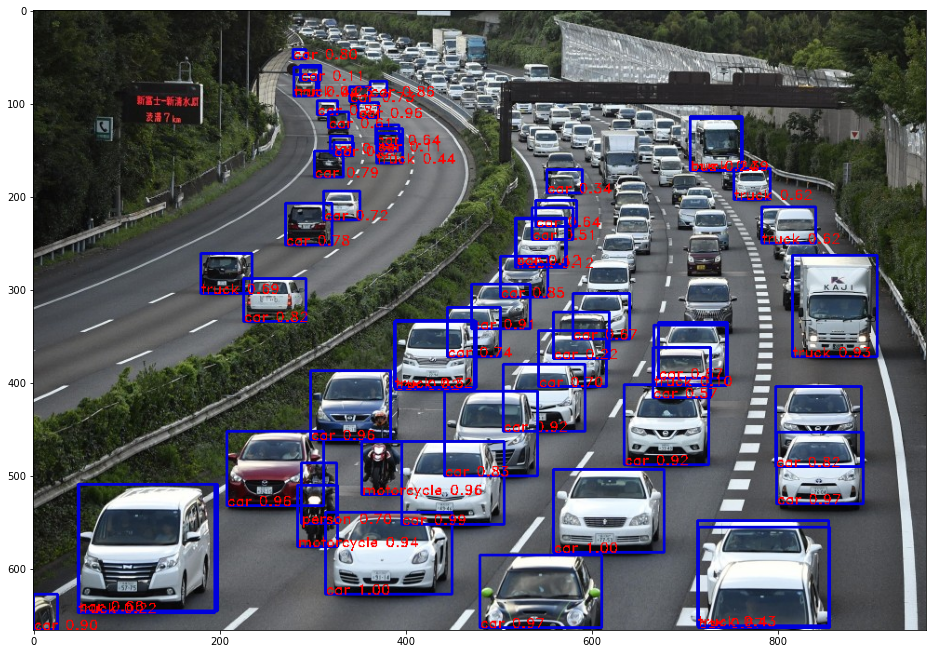

In [13]:
# Viz
fig = plt.figure(figsize=(16,16))
sample = cv2.imread(impath)
# rescale boxes to image size
boxes[:,0] *= sample.shape[1]
boxes[:,2] *= sample.shape[1]
boxes[:,1] *= sample.shape[0]
boxes[:,3] *= sample.shape[0]
for i, box in enumerate(boxes):
    cv2.rectangle(sample,
              (int(box[0]), int(box[1])),
              (int(box[2]), int(box[3])),
              220, 2)
    cv2.putText(sample, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),  
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction class

plt.imshow(sample[:,:,::-1])#BGR2RGB
plt.show()